# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [375]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
import sys
import pylab as pl
import numpy as np
import sklearn
import psycopg2 as psy
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

#### Step 2: Examine your data 

In [2]:
#loading data from csvs into three data frames
airports = pd.read_csv('airports.csv')
cancellations = pd.read_csv('airport_cancellations.csv')
operations = pd.read_csv('Airport_operations.csv')

In [3]:
print airports.shape
airports.head()

(5167, 13)


,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [4]:
print cancellations.shape
cancellations.head()

(805, 6)


,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [5]:
print operations.shape
operations.head()

(841, 15)


,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


### Intro: Write a problem statement / aim for this project

Objective: To analyze airport data to understand the cause of airport delays using Principal Component Analysis and other modeling techniques.

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [6]:
from sqlalchemy import create_engine

engine = create_engine("postgresql://@localhost:5432/airport")

In [7]:
%load_ext sql

//anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
//anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [8]:
%%sql 
postgresql://@localhost:5432/airport

u'Connected: @airport'

Load our csv files into tables

In [9]:
# airports.to_sql('airports', engine)
# operations.to_sql('operations', engine)
# cancellations.to_sql('cancellations',  engine)

In [380]:
%%sql 

SELECT * 
FROM airports 
LIMIT 5;

5 rows affected.


index,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,None,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.01933,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [381]:
%%sql 

SELECT *
FROM cancellations
LIMIT 5;

5 rows affected.


index,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [382]:
%%sql

SELECT *
FROM operations
LIMIT 5;

5 rows affected.


index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.6,9.79,2.29,11.2,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.4,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


Join airport_cancellations.csv and airports.csv into one table

In [383]:
%%sql

SELECT *
FROM airports, cancellations
WHERE cancellations."Airport" = airports."LocID"
LIMIT 5; 

5 rows affected.


index,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available,index_1,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,727,SJU,2014.0,280.0,241.0,72.0,31.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,726,SJU,2013.0,127.0,94.0,65.0,64.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,725,SJU,2012.0,174.0,141.0,62.0,41.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,724,SJU,2011.0,240.0,201.0,101.0,55.0
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,723,SJU,2010.0,258.0,207.0,82.0,45.0


In [384]:
%%sql
CREATE TABLE airport_data 
AS(
SELECT *
FROM airports, cancellations
WHERE cancellations."Airport" = airports."LocID"); 

(psycopg2.ProgrammingError) column "index" specified more than once
 [SQL: 'CREATE TABLE airport_data \nAS(\nSELECT *\nFROM airports, cancellations\nWHERE cancellations."Airport" = airports."LocID");']


Query the database for our intial data

In [15]:
#df = pd.read_sql()

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [804]:
#merging data from all tables into one data frame
df = pd.merge(operations, cancellations, left_on=['airport', 'year'], right_on=['Airport','Year'], how='outer')

In [805]:
#shape of data frame 
df.shape

(847, 21)

In [806]:
#nulls
sum(df.Airport.isnull())

42

In [807]:
#removing any row with missing airport
df = df[df['airport'].isnull() != True]
df = df[df['Airport'].isnull() !=True]

In [808]:
df = pd.merge(df, airports, left_on='airport', right_on='LocID', how='left')
df.shape

(799, 34)

In [809]:
#removing unnecessary and duplicate columns 
del df['Airport']
del df['Year']
del df['Key']
del df['LocID']
del df['AP_NAME']
del df['ALIAS']
del df['Facility Type']
del df['Boundary Data Available']

In [811]:
#renaming columns
df.columns = [u'airport', u'year', u'numdepart',
       u'numarriv', u'pctontimegatedepart',
       u'pctontimearptdepart', u'pctontimegatearriv',
       u'avggatedepartdelay', u'avgtaxiouttime',
       u'avgtaxioutdelay', u'avgarptdepartdelay',
       u'avgairbdelay', u'avgtaxiindelay',
       u'avgblockdelay', u'avggatearrivdelay',
       u'departcancellations', u'arrivcancellations',
       u'departdiversions', u'arrivdiversions', u'FAAregion',
       u'county', u'city', u'state', u'APtype', u'latitude', u'longitude']

In [812]:
#df2 copied for pivot table analysis
df2=df
df.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,arrivcancellations,departdiversions,arrivdiversions,FAAregion,county,city,state,APtype,latitude,longitude
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,235.0,71.0,46.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,190.0,61.0,33.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,329.0,71.0,124.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,304.0,107.0,45.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,300.0,79.0,42.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194


In [813]:
#pulling out important columns for data comparison
df1=df[[ u'year', u'numdepart',
       u'pctontimearptdepart', u'pctontimegatearriv',u'avgtaxiouttime', u'avgarptdepartdelay',
       u'departcancellations', u'arrivcancellations',
       u'departdiversions', u'arrivdiversions']]

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [814]:
#dummy variables for FAA region
df['key'] = range(len(df['FAAregion']))
df = pd.concat([df.drop('key',axis=1),pd.get_dummies(df['FAAregion'])], axis = 1)
df['key'] = range(len(df['APtype']))
df = pd.concat([df.drop('key',axis=1),pd.get_dummies(df['APtype'])], axis = 1)

#### 3.2 Format and Clean the Data

In [815]:
del df['FAAregion']
del df['county']
del df['city']
del df['state']
del df['APtype']
del df['latitude']
del df['longitude']

In [816]:
df.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,ACE,AEA,AGL,ANE,ANM,ASO,ASW,AWP,Federalized/Commercial,Public Use
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Part 4: Define the Data

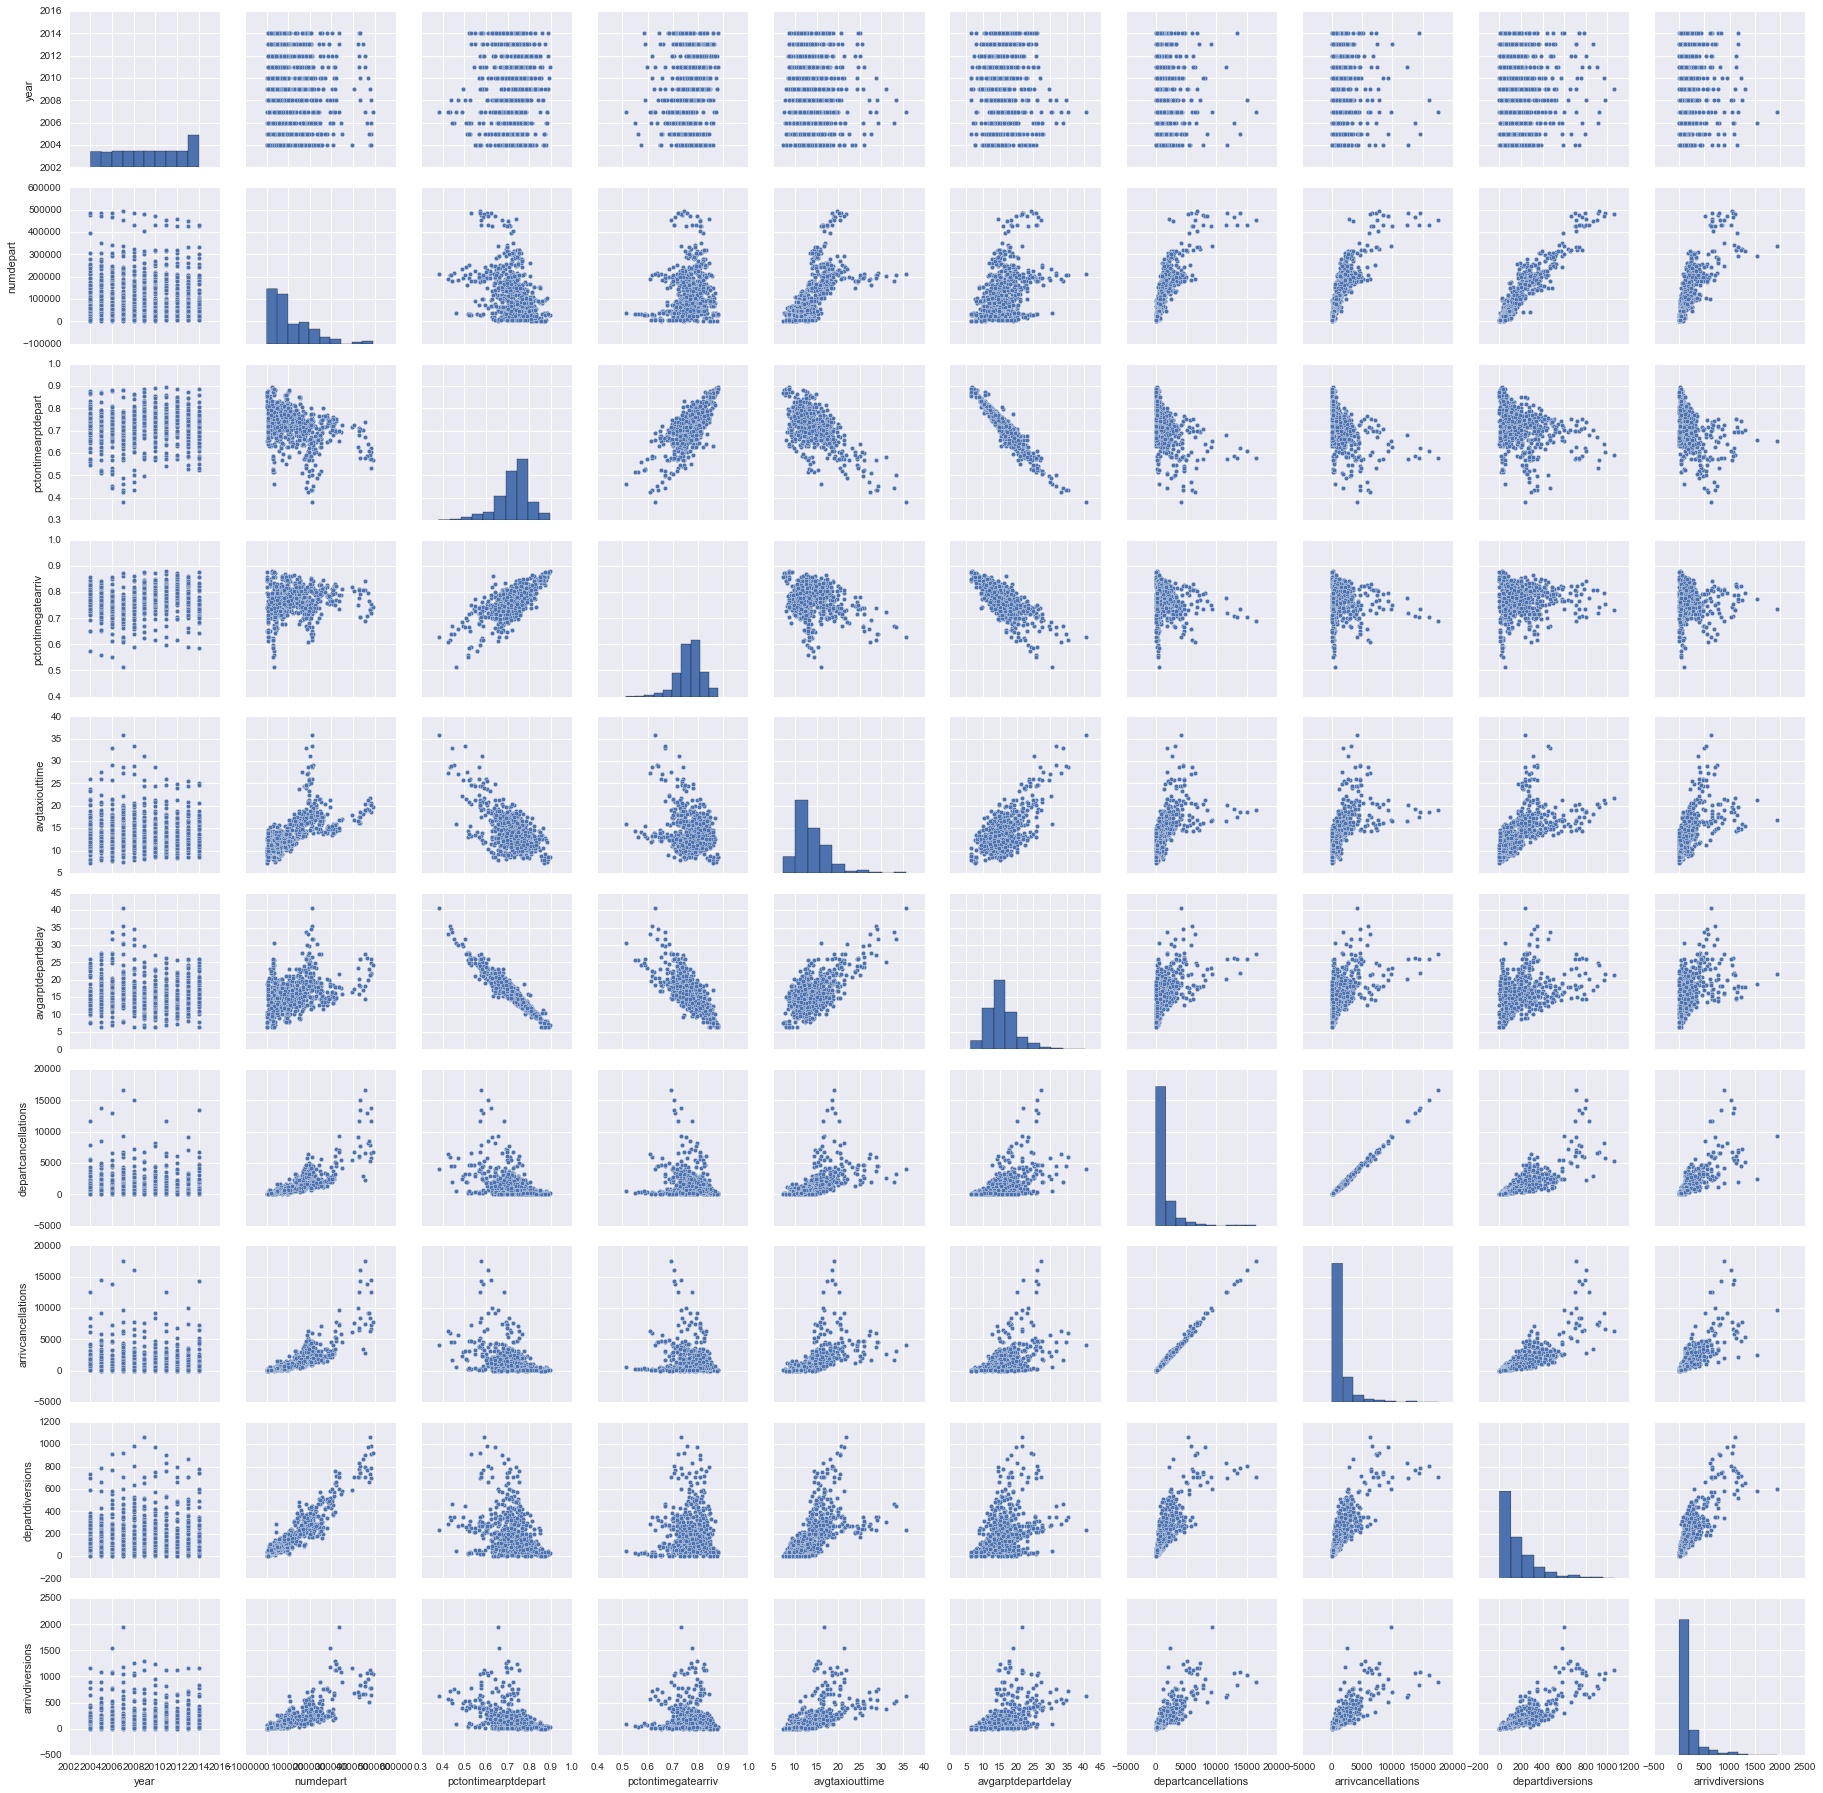

In [817]:
sns.pairplot(df1)

In [818]:
df2.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,departdiversions,arrivdiversions,FAAregion,county,city,state,APtype,latitude,longitude,key
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,71.0,46.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,0
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,61.0,33.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,1
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,71.0,124.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,2
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,107.0,45.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,3
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,79.0,42.0,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,4


In [819]:
airportpivot = pd.pivot_table(df2, index=['year'],columns=['FAAregion'],values = ['pctontimegatearriv'],aggfunc=np.mean)
airportpivot

pctontimegatearriv                                          \
FAAregion                AAL       ACE       AEA       AGL       ANE   
year                                                                   
2004.0                0.6502  0.784533  0.738025  0.770313  0.763550   
2005.0                0.6955  0.773967  0.717667  0.767112  0.743675   
2006.0                0.7110  0.756967  0.702458  0.753811  0.728575   
2007.0                0.7196  0.728200  0.674117  0.725967  0.701450   
2008.0                0.7573  0.739667  0.713825  0.760689  0.742350   
2009.0                0.8264  0.788633  0.740750  0.811025  0.775375   
2010.0                0.8045  0.782833  0.746000  0.793600  0.762325   
2011.0                0.8292  0.778000  0.728200  0.790900  0.759450   
2012.0                0.8521  0.800833  0.755225  0.809044  0.777200   
2013.0                0.8631  0.756667  0.726283  0.770033  0.742750   
2014.0                0.8600  0.735833  0.723442  0.749350  0.741400   

                                                   
FAAregion       ANM       ASO       ASW       AWP  
year                                               
2004.0     0.814000  0.762581  0.775050  0.789000  
2005.0     0.799475  0.745844  0.779037  0.783600  
2006.0     0.784650  0.747125  0.761912  0.771773  
2007.0     0.765175  0.728800  0.738562  0.774112  
2008.0     0.792200  0.746387  0.761987  0.784635  
2009.0     0.828575  0.775263  0.794837  0.818765  
2010.0     0.832250  0.778419  0.785587  0.804524  
2011.0     0.833700  0.778444  0.790262  0.802119  
2012.0     0.845750  0.796531  0.796900  0.813237  
2013.0     0.815125  0.764288  0.756963  0.794375  
2014.0     0.808325  0.753731  0.736587  0.772163

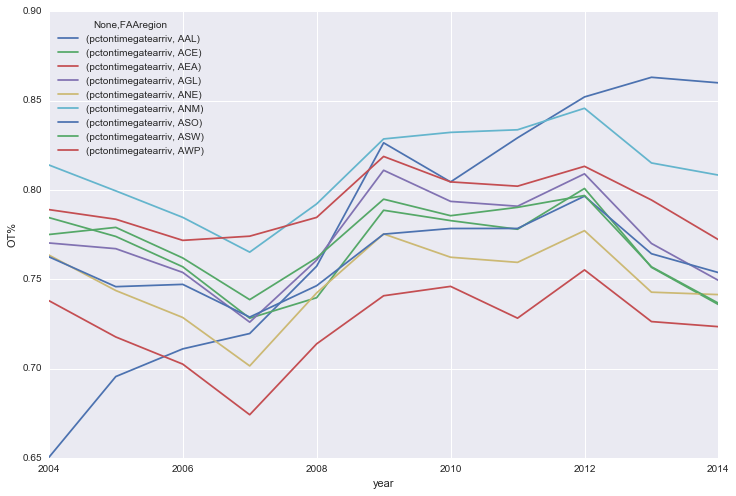

In [820]:
airportpivot.plot(kind='line',figsize=(12,8))
plt.ylabel('OT%')

The above graph shows the mean on-time gate arrival percent for each FAA region from 2004-2014. Most FAA regions remain pretty constant with ANM consistently the highest on-time percent. AEA remained at the lowest on-time percent for this period. AAL is the only region to show an improvement -- and a dramatic one at that. In 2004, this region's OT% was 0.65 (with the next lowest at 0.73), and in 2014 increased their OT% to the highest of all regions to 0.86 (with the second best at 0.81).

In [821]:
airportpivot2 = pd.pivot_table(df2, index=['FAAregion'],values = ['numdepart'],aggfunc=np.mean)
airportpivot2

,numdepart
FAAregion,
AAL,67627.545455
ACE,71575.242424
AEA,116598.803030
AGL,148493.404255
ANE,68774.590909
ANM,179045.409091
ASO,119545.732955
ASW,115189.011364
AWP,91117.022599


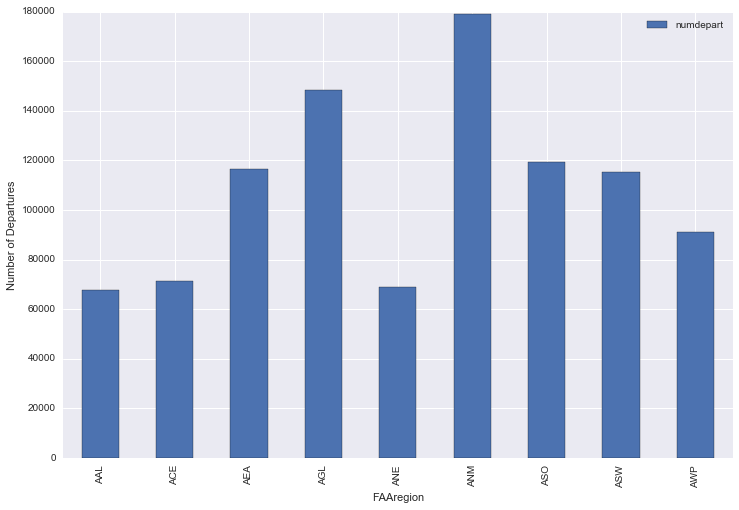

In [822]:
airportpivot2.plot(kind='bar',figsize = (12,8))
plt.ylabel('Number of Departures')

The above graph simply shows FAA region by size (number of departures). It's important to note that the largest region, ANM, had the consistently highest OT% over the 10 year span.

## K-Means Clustering

In [857]:
#setting X and Y variables, scaling data using standard scaler, fitting the kmeans model with k = 3
x = df.ix[:,2:19]
y = df.ix[:,0]
X = x.as_matrix(columns=None)
X = StandardScaler().fit_transform(X)
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [824]:
#silhouette score for kmeans model
metrics.silhouette_score(X, labels, metric='euclidean')

0.24565981727070732

## Hierarchical Clustering

In [825]:
Z = linkage(X, 'complete')
c, coph_dists = cophenet(Z, pdist(X))
c

0.78229163061756968

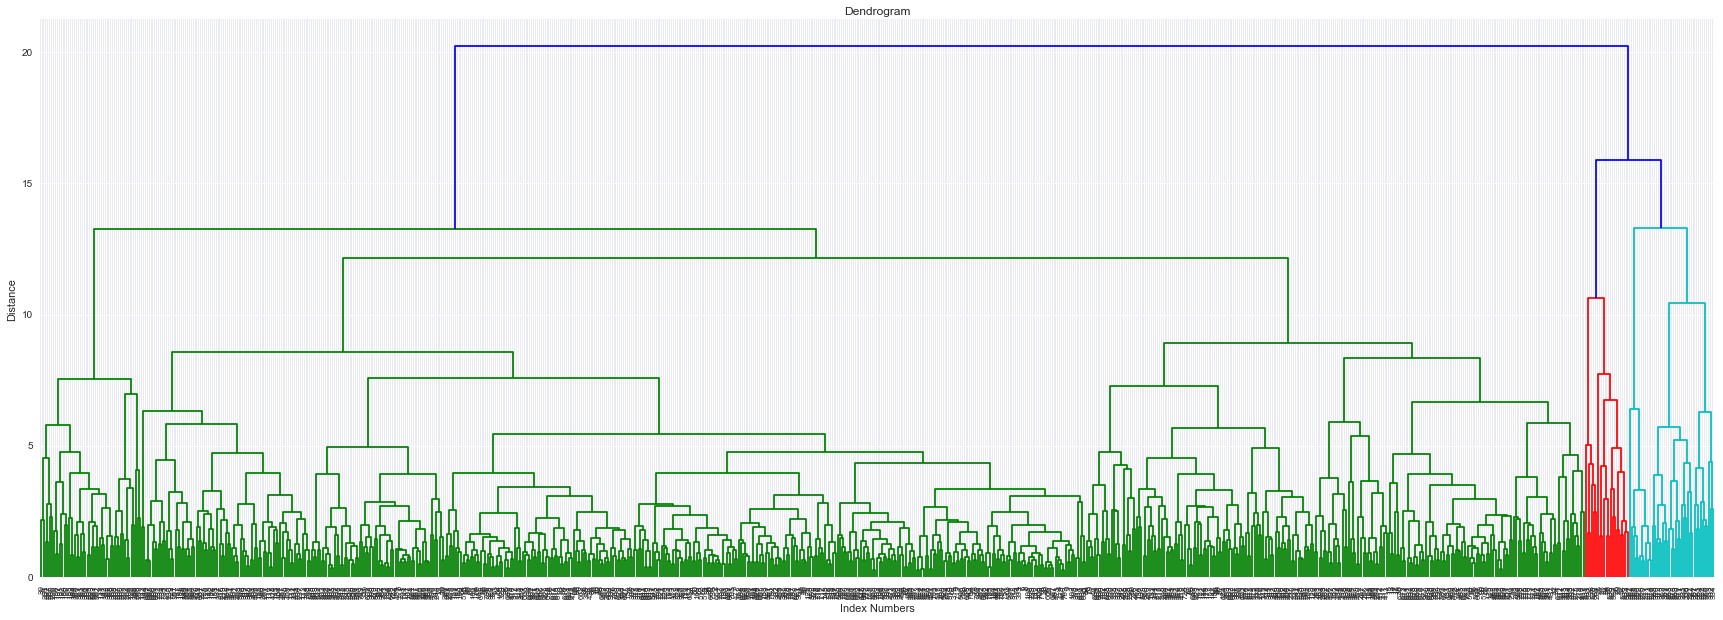

In [826]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

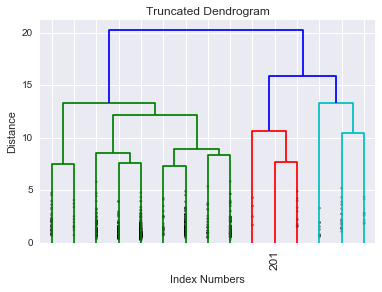

In [827]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [828]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')

In [829]:
metrics.silhouette_score(X, clusters, metric='euclidean')

0.53880398562887843

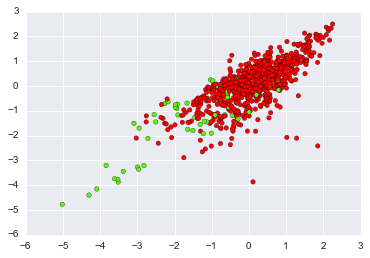

In [830]:
plt.scatter(X[:,4], X[:,2], c=clusters, cmap='prism')
plt.show()

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: PCA turns the feature values into simpler components. While this makes for running a less complex model, you no longer have your features to analyze.

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: PCA

#### 5.1 Conduct the PCA

In [831]:
covMat1 = np.cov(X.T)
eigenValues, eigenVectors = np.linalg.eig(covMat1)

In [832]:
eigenValues

array([  9.17680918e+00,   4.16210652e+00,   1.21645796e+00,
         6.50383255e-01,   5.10203215e-01,   4.20437718e-01,
         2.47407511e-01,   1.90068175e-01,   1.65777857e-01,
         1.43298219e-01,   6.19936947e-02,   5.37682509e-02,
         1.49627279e-02,   4.86205637e-03,   1.71481675e-04,
         9.58506528e-04,   1.63693067e-03])

In [833]:
eigenVectors

array([[  2.58851923e-01,  -2.72016612e-01,   8.04227462e-02,
          9.47149758e-02,  -1.20533810e-03,  -2.55678870e-01,
         -3.13898448e-01,  -1.20701687e-01,  -9.86729484e-02,
         -1.08860234e-02,  -1.59016211e-01,   3.54936104e-01,
         -2.09098287e-02,   4.81052435e-03,   7.09202065e-01,
         -2.00370848e-02,   1.18137130e-02],
       [  2.58562442e-01,  -2.72629981e-01,   8.24742689e-02,
          9.62511299e-02,   7.57552921e-04,  -2.51721414e-01,
         -3.11379652e-01,  -1.22980356e-01,  -9.88952600e-02,
         -2.02758426e-02,  -1.64242428e-01,   3.64148334e-01,
         -2.58808836e-02,   2.64069931e-02,  -7.03981981e-01,
          2.34736128e-02,  -5.15910364e-03],
       [ -1.64032375e-01,  -3.50338579e-01,  -3.30072948e-01,
         -2.68708898e-01,  -6.30291007e-03,   2.82442118e-01,
         -2.43484783e-02,  -2.88932009e-01,   9.58530500e-02,
          1.96119027e-01,   2.10115451e-01,   2.23669191e-01,
         -1.60177415e-01,  -5.66825119e-01

In [834]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

9.17680918441
4.1621065165
1.21645795793
0.650383255261
0.510203215266
0.420437717613
0.247407510965
0.190068175185
0.165777857314
0.143298218936
0.0619936947224
0.053768250943
0.014962727851
0.00486205637359
0.00163693067387
0.000958506528141
0.000171481675199


In [835]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
varExpl

[53.913669507183606,
 24.452337481899932,
 7.1466793081408158,
 3.8209956393906701,
 2.9974391944526602,
 2.4700677218241469,
 1.4535168501077635,
 1.1166487800724905,
 0.97394338612126574,
 0.84187571752338908,
 0.36421238598591837,
 0.31588797947823066,
 0.087905888427648571,
 0.0285645364508876,
 0.0096169526448260552,
 0.0056312170320022186,
 0.0010074532637043569]

In [836]:
cvarex = np.cumsum(varExpl)
cvarex

array([ 53.91366951,  78.36600699,  85.5126863 ,  89.33368194,
        92.33112113,  94.80118885,  96.2547057 ,  97.37135448,
        98.34529787,  99.18717359,  99.55138597,  99.86727395,
        99.95517984,  99.98374438,  99.99336133,  99.99899255, 100.        ])

In [837]:
airports_pca = PCA(n_components=3)
airports_pca.fit(X)
pcaX = airports_pca.transform(X)

In [838]:
dfpca = pd.DataFrame(pcaX,columns=['pca1','pca2','pca3'])
dfpca.head()

,pca1,pca2,pca3
0,-2.660194,0.391023,-0.030782
1,-3.043688,0.763778,-0.026486
2,-2.428300,0.118742,-0.376964
3,-1.985310,-0.090682,-0.192776
4,-2.554874,0.340639,-0.202927


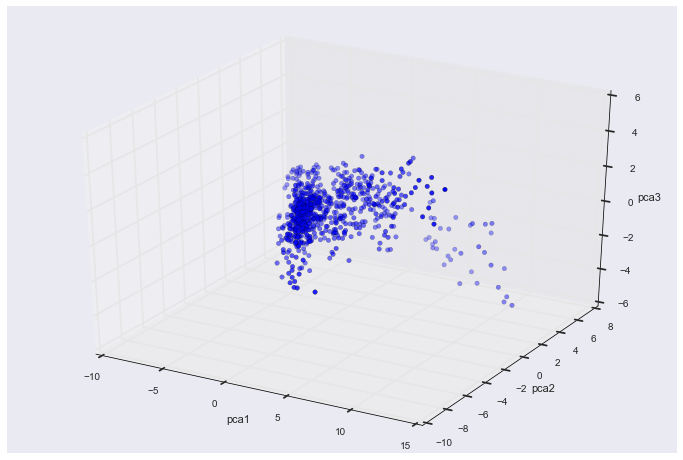

In [839]:
d3 = plt.figure(figsize=(12,8)).gca(projection='3d')
d3.scatter(dfpca.pca1, dfpca.pca2, dfpca.pca3)
d3.set_xlabel('pca1')
d3.set_ylabel('pca2')
d3.set_zlabel('pca3')
plt.show()

In [840]:
# plt.figure(figsize=(9,7))

# component_number = [1,2,3]

# plt.plot(component_number, cvarex, lw=7)

# plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
# plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


# ax = plt.gca()
# ax.set_xlim([1,3])
# ax.set_ylim([-5,105])

# ax.set_ylabel('cumulative variance explained', fontsize=16)
# ax.set_xlabel('component', fontsize=16)

# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(12) 
    
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(12) 
    
# ax.set_title('component vs cumulative variance explained\n', fontsize=20)

# plt.show()

In [841]:
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(pcaX)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
metrics.silhouette_score(pcaX, labels, metric='euclidean')

0.3102400905703771

In [842]:
Z = linkage(pcaX, 'complete')
c, coph_dists = cophenet(Z, pdist(pcaX))
c

0.66974594887947136

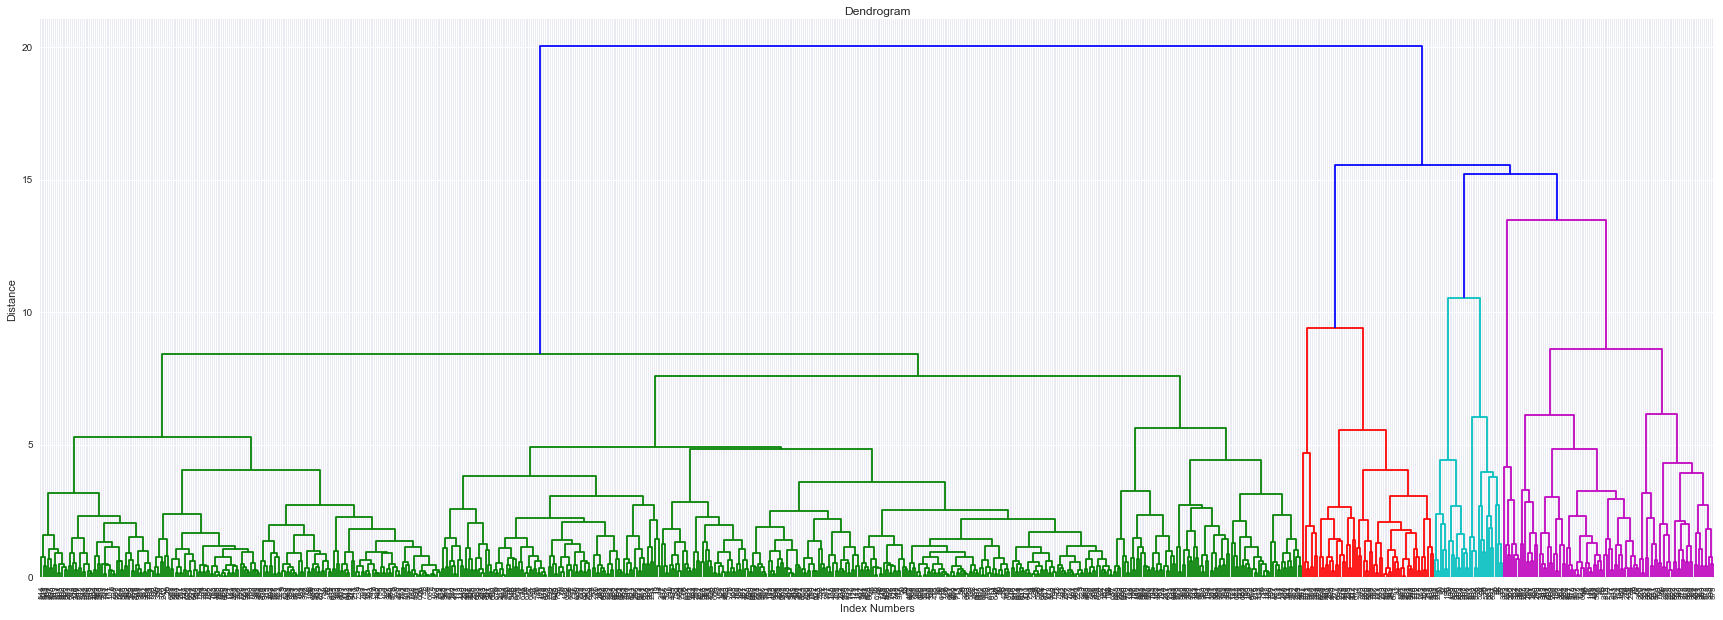

In [843]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

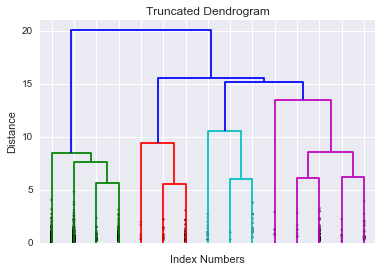

In [844]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [845]:
max_d = 15
clusters = fcluster(Z, max_d, criterion='distance')
metrics.silhouette_score(pcaX, clusters, metric='euclidean')

0.39872949695100418

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [846]:
df['delaybinary']=df.avggatearrivdelay.apply(lambda x: 1 if x > np.median(df.avggatearrivdelay) else 0)
df.head()

,airport,year,numdepart,numarriv,pctontimegatedepart,pctontimearptdepart,pctontimegatearriv,avggatedepartdelay,avgtaxiouttime,avgtaxioutdelay,...,AEA,AGL,ANE,ANM,ASO,ASW,AWP,Federalized/Commercial,Public Use,delaybinary
0,ABQ,2004.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,ABQ,2005.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,ABQ,2006.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,ABQ,2007.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,ABQ,2008.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [847]:
del df['airport']
del df['pctontimegatedepart']
del df['pctontimearptdepart']
del df['pctontimegatearriv']


In [851]:
del df['avggatearrivdelay']

In [852]:
Xlogreg = df.ix[:,:-1]
ylogreg = df.ix[:,-1]
lr = model = LogisticRegression()

In [853]:
selector = SelectKBest(f_classif, k=5)
selected_data = selector.fit_transform(Xlogreg, ylogreg)
kbest_columns = Xlogreg.columns[selector.get_support()]
Xbest = pd.DataFrame(selected_data, columns=kbest_columns)

X_train, X_test, y_train, y_test = train_test_split(Xbest, ylogreg, stratify=y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.86206896551724133

In [854]:
coefs = model.coef_
coeflist=[]
for i in coefs[0]:
    coeflist.append(i)
coefdf = pd.DataFrame(coeflist, index = Xbest.columns)
coefdf = coefdf.sort_values(0, ascending = False)
coefdf = coefdf[coefdf.index != 'constant']
coefdf.columns = ['Coef']
coefdf

,Coef
avgblockdelay,0.648999
avggatedepartdelay,0.554710
AEA,0.303849
avgarptdepartdelay,-0.088258
AWP,-0.843641


In [855]:
from sklearn.metrics import classification_report

classification_report(y_test, y_pred)

'             precision    recall  f1-score   support\n\n          0       0.84      0.87      0.86       137\n          1       0.88      0.86      0.87       153\n\navg / total       0.86      0.86      0.86       290\n'

In [856]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[119,  18],
       [ 22, 131]])

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

http://tptirrell.github.io/AirportDelays/

Which operational features are most correlated with delays?

After running the logistic regression above, the features most correlated with delays are: Avg Block Delay, Airport Departure Delay, Block Delay, and Gate Depart Delay.

What should the airport's next steps be?

First,Take a closer look at the AAL region to determine what additional conditions were present that caused the dramatic increase in on-time percentage.
Secondly, ANM, for being the region with the most departures, had the highest consistent OT%. What conditions were present here to maintain that rate?
Finally, According to the logistic regression, block delay is the single largest contributor to gate arrival delays. How can we decrease this moving forward?